# Federated Learning with Clara Train SDK

Medical data is sensitive and needs to be protected. And even after anonymization processes, it is often infeasible to collect and share patient data from several institutions in a centralised data lake. This poses challenges for training machine learning algorithms, such as deep convolutional networks, which require extensive and balanced data sets for training and validation.


Federated learning (FL) is a learning paradigm that sidesteps this difficulty: instead of pooling the data, the machine learning process is executed locally at each participating institution and only intermediate model training updates are shared among them. It  thereby  allows to train algorithms collaboratively without exchanging the underlyling datasets and neatly addresses the problem of data governance and privacy that arise when pooling medical data. There are different FL communication architectures, such as the Client-server approach via hub and spokes, a decentralized architecture via peer-to-peer or hybrid variants. The FL tool in the Clara Train SDK is a client-server architecture, in which a federated server manages the aggregation and distribution. 

In this notebook, we show you how to set up this FL tool locally. In particular, we will explore the FL APIs and relevant Medical Model Archive (MMAR) items.


## Overview

Federated Learning in Clara Train SDK uses a client-server architecture. The image below gives you an overview. For details about the components, please see our [documentation](https://docs.nvidia.com/clara/tlt-mi/clara-train-sdk-v2.0/nvmidl/additional_features/federated_learning.html?highlight=federated).  

The key things to note are:
* A server is responsible for **managing training, keeping best model and aggregating gradients**.
* Clients are responsible for **training local model** and sending updates (gradients) to server.
* **No data from the dataset is shared** between clients or with server.
* To ensure **privacy**, all communication with server is secured.
* Additional privacy-preserving mechanisms can be enabled.

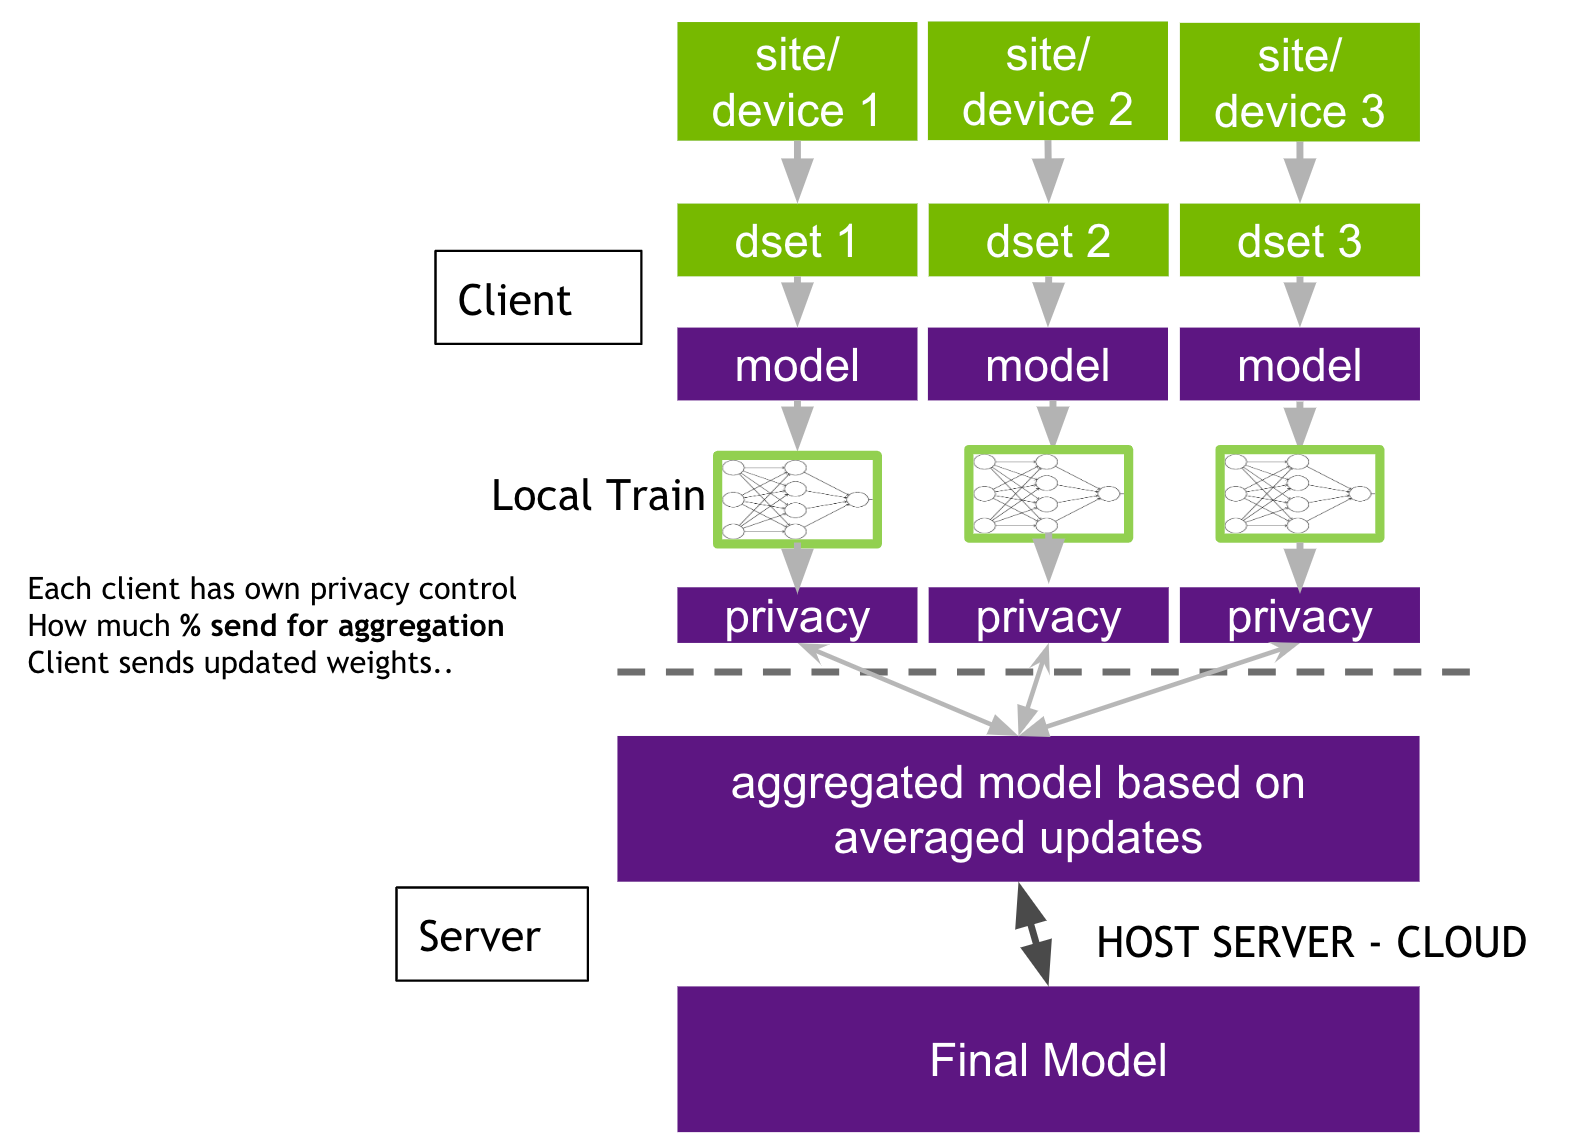

In [2]:
from IPython.display import display, Image
display(Image(filename='figures/fl_overview.png'))

## Demo Setup

This demo requires a few things in order to run:
1. **Clara Train SDK**, which is hosted on NGC: https://ngc.nvidia.com/catalog/containers/nvidia:clara-train-sdk
2. **Docker**: Docker is required to run the CLARA container.
3. **Python & Jupyter**: Python with jupyter notebook installed.
4. **Dataset**: In this demo, we will work on the spleen data from the [medical decathlon](http://medicaldecathlon.com/). Please download the ["Task09_Spleen.tar" dataset](https://goo.gl/QzVZcm)
5. **Multiple GPUs**: Federated Learning is set up between different clients. For the sake of this demo, we'll set it up on single machine with 2 GPUs. Clara FL can also be set up for multiple nodes.


To make it easier, let's set a couple of variables. Please edit the following variables:
* **DATASET_PATH**: Set this to the path where you downloaded the medical decathalon dataset.

In [7]:
DOCKER_NAME='nvcr.io/nvidia/clara-train-sdk:v3.0'
# 这个是物理机的数据集的路径
DATASET_PREFIX='/home/liuyuan/shu_codes/datasets/brats'
# RESNET 似乎不使用 pretrain
PRETRAIN_PATH='/home/liuyuan/shu_codes/pretrain_models/for_clara'

Please enter the machine IP of local machine here (for tensorboard)

In [ ]:
MY_IP="172.17.0.1"

In the following, we assume that you downloaded and installed the upper requirements. Let's see how easy it is to train a spleen segmentation with Clara FL!

### MMAR

In Clara, we provide [MMAR (Model archive)](https://docs.nvidia.com/clara/tlt-mi/clara-train-sdk-v3.0/nvmidl/mmar.html) that contains everything necessary to get started. 

In this notebook, we will use `clara_seg_ct_spleen_fl_demo` MMAR and explore how it makes getting started and configuring training very easy.

In [8]:
MMAR_FOLDER="clara_seg_ct_brats_fl"
!mkdir -p {MMAR_FOLDER}/logs

Let's have a look at the folder structure and the files that are important for the FL setup.

In [2]:
!ls {MMAR_FOLDER}

commands  config  docs	eval  logs  models  resources


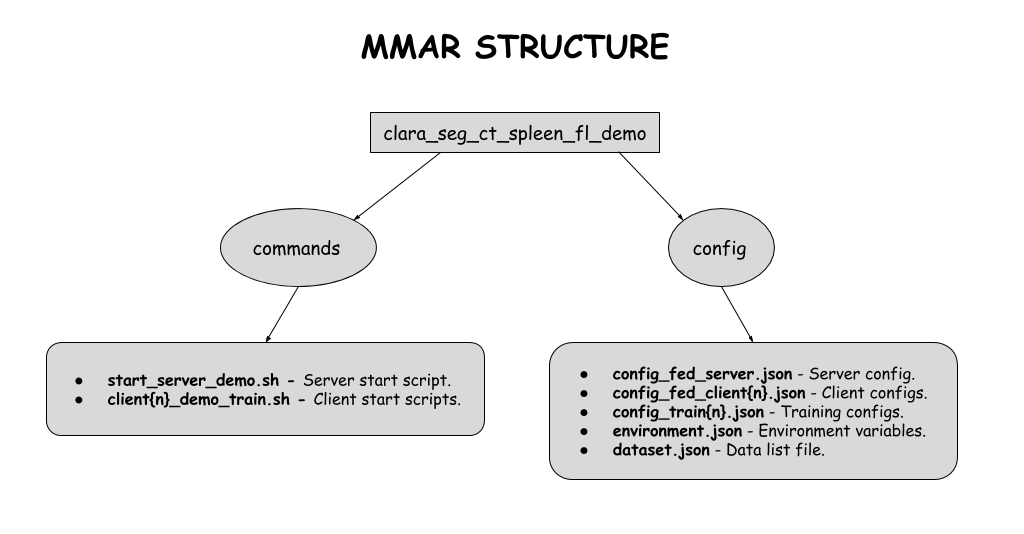

In [3]:
from IPython.display import Image
display(Image(filename='figures/fed_learn.png'))

As you can see, the structure for MMAR and the files are consistent with the general Clara training procedure, which is explained in the Clara train notebooks. Therefore we will focus on the FL-specific files. Here are details of the above shown structure:

* **`commands`** : This folder contains all commands needed to run server and clients:
    * **`start_server_demo.sh`** : Script used to start federated server.
    * **`client{n}_demo_train.sh`** : Script used to start client N. Each client will have it's own start script.

* **`config`**: This folder contains configuration files for above commands:
    * **`config_fed_server.json`** : Server configuration used in `start_server_demo.sh`.
    * **`config_fed_client{n}.json`** : Client configuration used in `client{n}_demo_train.sh`.
        * For this simple example, both clients use the same configuration. BRATS 目前也是这样设置
    * **`config_train{n}.json`** : Training configuration for clients.
        * For this simple example, both clients use the same training configuration.
    * **`environment.json`** : Environment variables for training like data paths etc.
    * **`dataset.json`** : Data list file. **这个文件似乎在数据集的目录里, 包含了测试的数据**

### Tensorboard

During training, we want to check the training progress. We will do this with tensorboard and both clients are configured to write tensorboard logs to the same file folder. The following commands starts a separate docker instance to run tensorboard, and provide a URL for accessing it.


In [3]:
%%bash --bg
docker stop tensorboard

In [108]:
%%bash -s "$MMAR_FOLDER" "$DOCKER_NAME" "$DATASET_PREFIX"
docker run --runtime=nvidia -dt --name tensorboard --rm --shm-size=10g --ulimit memlock=-1 --ulimit stack=67108864 \
    -v $PWD:/mmar \
    -v $3:/workspace/data \
    -p 19020:19020 \
    $2 \
    bash -c "tensorboard --host 0.0.0.0 --port 19020 --logdir /mmar/$1/models/"

47a63c8820f65936f0e273127d6a49c341d82b6106a40f38671ba4abb9414a9d


After executing the cell (it may take a while if you are pulling the container for the first time), you can click on the link to open tensorboard in a new tab.

Now that we know how MMAR is structured and tensorboard is running, we can configure the server and the clients for FL. 

## Launch Server

The following diagram shows the server workflow:

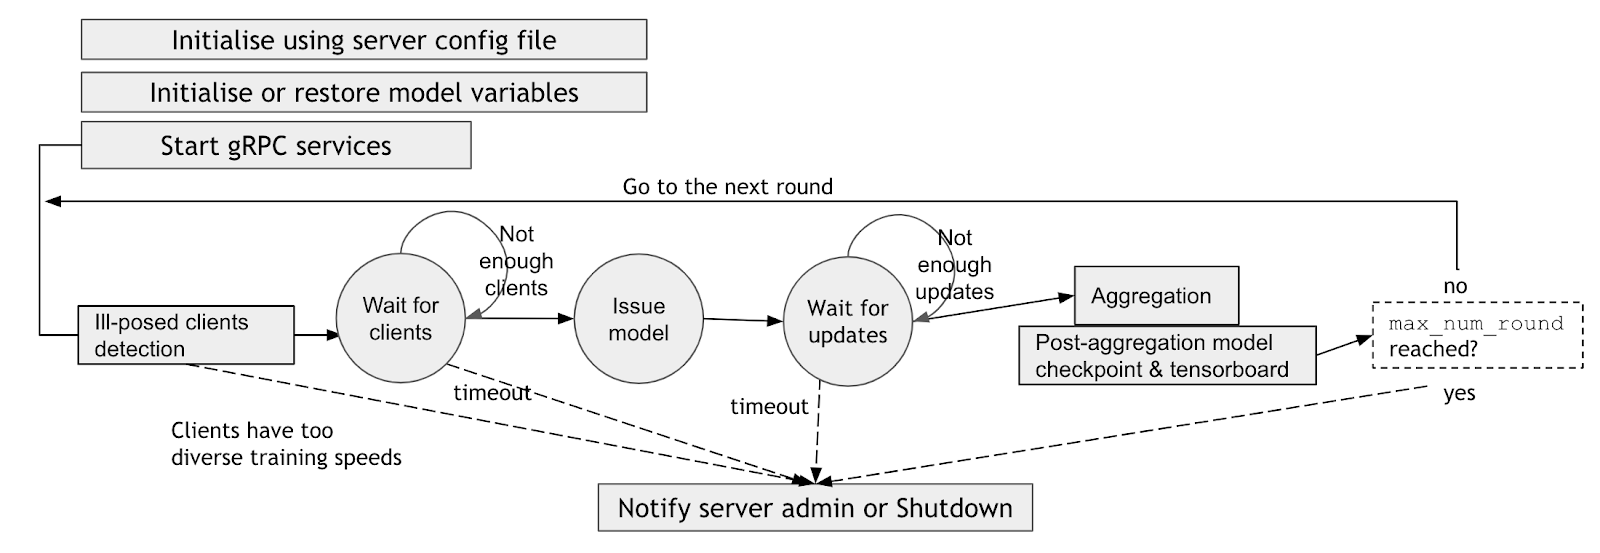

In [11]:
display(Image(filename='figures/fl_server_workflow.png'))

###  Configuration 
A federated server is responsible for:
1. Initialising a global model at federated round 0
1. Sharing the global model with all clients
1. Synchronising model updates from multiple clients
1. Updating the global model when sufficient model updates received

The configurations for the server are specified in the "config_fed_server.json" file: 

In [99]:
! cat {MMAR_FOLDER}/config/config_fed_server.json

{
    "servers": [
        {
            "name": "brats_segmentation",
            "service": {
                "target": "192.168.1.101:28004",
                "options": [
                    ["grpc.max_send_message_length",    1000000000],
                    ["grpc.max_receive_message_length", 1000000000]
                ]
            },
            "ssl_private_key": "resources/certs/server.key",
            "ssl_cert": "resources/certs/server.crt",
            "ssl_root_cert": "resources/certs/rootCA.pem",
            "min_num_clients": 2,
            "max_num_clients": 100,
            "wait_after_min_clients": 10,
            "heart_beat_timeout": 60000,
            "start_round": 0,
            "num_rounds": 200,
            "exclude_vars": "dummy",
            "num_server_workers": 100
        }
    ],
    "aggregator":
      {
        "name": "ModelAggregator",
        "args": {
          "exclude_vars": "dummy"
        }
      }
}


In the "config_fed_server.json" shown above, the server is configured to
1. listen on port 8002 on the localhost (`target` set to `localhost:8002`)
2. wait for at least 2 clients' update submission at each federated round (`min_num_clients` set to `2`)
3. Wait 10 seconds after the min no of clients join before starting rounds (`wait_after_min_clients` is set to 10).
4. `ssl_*` parameters are related to authentication.
5. Client sends heartbeat every minutes. `heart_beat_timeout` is set to detect if client is killed.
6. `aggregator` defines the type of aggregation. You can also point here to your own aggregator.

<font color='red'>Note: In this tutorial, we'll be using insecure training so the `ssl_*` parameters are ignored.</font>

**BEFORE YOU MOVE FORWARD, PLEASE REPLACE THE IP ADDRESS (localhost) IN "target": "< IP_address > :8002" with the IP ADDRESS OF YOUR MACHINE.**
You can do this by navigating to the file explorer of this jupyter notebook and editing it there or overwriting the file here.

###  Test the server 

Let's checkout `start_server_demo.sh` and start our server. We can start the server and run in the background:

In [74]:
!cat {MMAR_FOLDER}/commands/start_server_demo.sh



#!/usr/bin/env bash

my_dir="$(dirname "$0")"
. $my_dir/set_env.sh

echo "MMAR_ROOT set to $MMAR_ROOT"

export CUDA_VISIBLE_DEVICES=

# Data list containing all data
CONFIG_FILE=config/config_train.json
SERVER_FILE=config/config_fed_server.json
ENVIRONMENT_FILE=config/environment.json

python3 -u  -m nvmidl.apps.fed_learn.server.fed_aggregate \
    -m $MMAR_ROOT \
    -c $CONFIG_FILE \
    -e $ENVIRONMENT_FILE \
    -s $SERVER_FILE \
    --set \
    DATASET_JSON=$MMAR_ROOT/config/fl_dataset_0.json \
    MMAR_CKPT_DIR="models" \
    secure_train=false




Let's use `start_server_demo.sh` to start the container for the server (here named 'server_app'):

In [97]:
%%bash --bg
docker stop server_app

In [98]:
%%bash -s "$DOCKER_NAME" "$MMAR_FOLDER" "$PRETRAIN_PATH" "$DATASET_PREFIX"
docker run --name server_app --rm -dt --shm-size=10g --ulimit memlock=-1 --ulimit stack=67108864 \
-v $PWD:/mmar \
-v $3:/workspace/pretrain \
-v $4:/workspace/data \
--ipc=host --net=host \
$1 \
bash -c "bash /mmar/$2/commands/start_server_demo.sh | tee /mmar/$2/logs/server_log.tmp"

ec7a9dcca252bfa73e17a2718cbe579a17136bfe029b8ef208ea0f4b5583b4f9


Give it some time to start and then check the server's log:

In [94]:
!cat {MMAR_FOLDER}/logs/server_log.tmp

Replacing some pre-defined components...
'/mmar/clara_seg_ct_brats_fl/commands/../components/server_model_manager.py' -> '/opt/nvidia/fed_learn/server/server_model_manager.py'
'/mmar/clara_seg_ct_brats_fl/commands/../components/fed_server.py' -> '/opt/nvidia/fed_learn/server/fed_server.py'
MMAR_ROOT set to /mmar/clara_seg_ct_brats_fl/commands/..
2020-09-23 02:39:15,824 - __main__ - INFO - Starting aggregation server with config:
2020-09-23 02:39:15,824 - __main__ - INFO - config/config_fed_server.json
Number of samples: 74
Data Property: {'task': 'segmentation', 'num_channels': 4, 'num_label_channels': 3, 'data_format': 'channels_first', 'label_format': None, 'crop_size': [128, 128, 128], 'num_data_dims': 3}
SegResnet init, num_classes: 3 data_format: channels_first
SegResnet net_config:
num_classes      => 3
data_format      => channels_first
blocks_down      => 1,2,2,4
blocks_up        => 1,1,1
init_filters     => 16
use_batchnorm    => False
use_groupnorm    => True
use_groupnormG  

In [82]:
%%bash --bg
docker stop server_app_debug

In [79]:
%%bash -s "$DOCKER_NAME" "$MMAR_FOLDER" "$PRETRAIN_PATH" "$DATASET_PREFIX"
docker run --name server_app_debug --rm -dt --shm-size=10g --ulimit memlock=-1 --ulimit stack=67108864 \
-v $PWD:/mmar \
-v $3:/workspace/pretrain \
-v $4:/workspace/data \
--ipc=host --net=host \
$1 \
bash -c "bash /mmar/$2/commands/start_server_demo.sh | tee /mmar/$2/logs/server_log_debug.tmp"

927559bc807cf7edc047b521352ac772d81947b52967841c7a4772e740c5cb91


In [81]:
!cat {MMAR_FOLDER}/logs/server_log_debug.tmp

MMAR_ROOT set to /mmar/clara_seg_ct_brats_fl/commands/..
2020-09-22 14:05:28,013 - __main__ - INFO - Starting aggregation server with config:
2020-09-22 14:05:28,013 - __main__ - INFO - config/config_fed_server.json
Number of samples: 74
Data Property: {'task': 'segmentation', 'num_channels': 4, 'num_label_channels': 3, 'data_format': 'channels_first', 'label_format': None, 'crop_size': [128, 128, 128], 'num_data_dims': 3}
SegResnet init, num_classes: 3 data_format: channels_first
SegResnet net_config:
num_classes      => 3
data_format      => channels_first
blocks_down      => 1,2,2,4
blocks_up        => 1,1,1
init_filters     => 16
use_batchnorm    => False
use_groupnorm    => True
use_groupnormG   => 8
reg_weight       => 1e-05
dropout_prob     => 0.2
final_activation => sigmoid
use_vae          => False
-----------------
SegResnet inputs  [None, 4, 128, 128, 128] use_bias False filters 16 blocks_down  [1, 2, 2, 4] blocks_up [1, 1, 1]
LayerDown [ 0 : 0 ] shape [None, 16, 128, 128, 1

If the output of the previous cell shows **FederatedServer - INFO - starting insecure server at < your_ip >:8002** it means that the configuration works fine and the server is up and running. 
If not, try to execute previous cell again. Maybe it was still in the process. Ready? Good, server is there, let's launch the clients.


##  Lauch Client

The following diagram shows the client workflow:

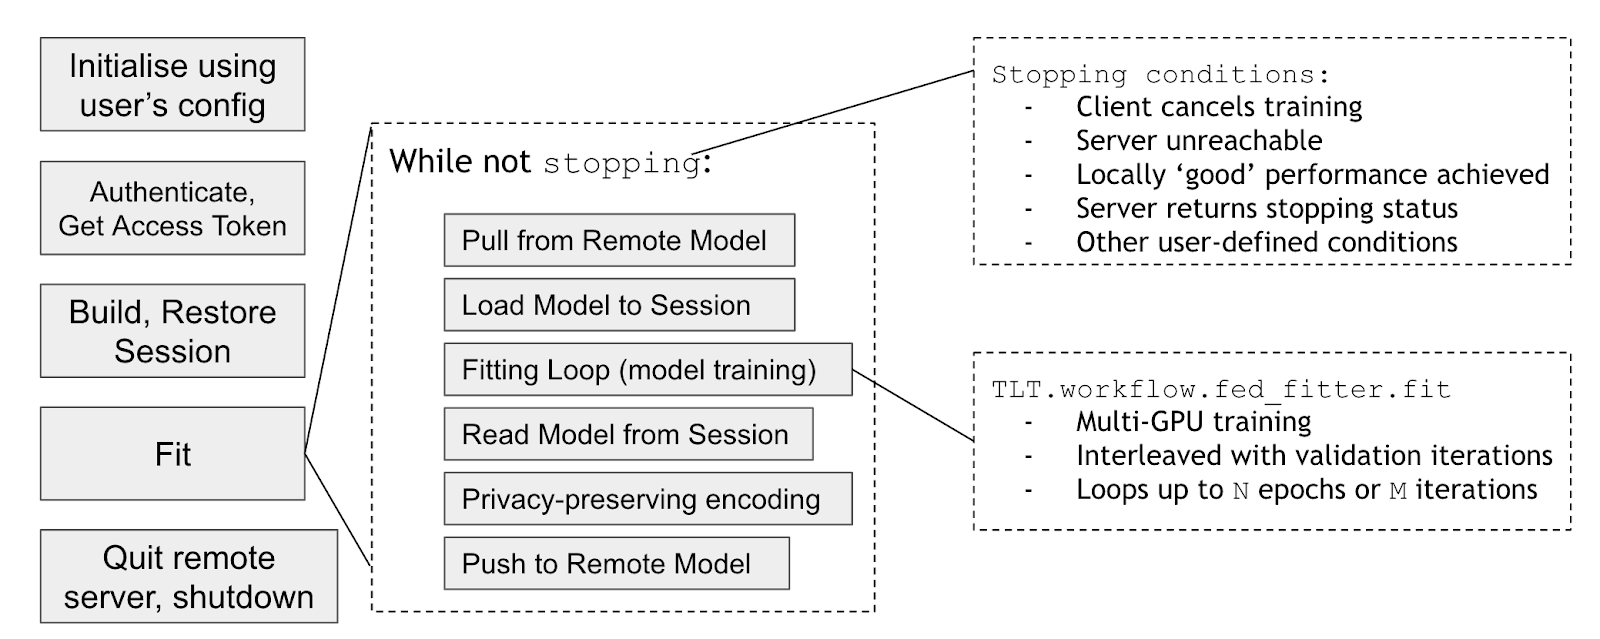

In [21]:
display(Image(filename='figures/fl_client_workflow.png'))

###  Configuration
A federated client will:
1. download the global model
1. train the model with local training data
1. upload `delta_w` (the difference between the updated model and the global model) to the server

Let's inspect the `config_fed_client.json`:

In [100]:
! cat {MMAR_FOLDER}/config/config_fed_client.json

{
    "servers": [
        {
            "name": "brats_segmentation",
            "service": {
                "target": "192.168.1.101:28004",
                "options": [
                    ["grpc.max_send_message_length",    1000000000],
                    ["grpc.max_receive_message_length", 1000000000]
                ]
            }
        }
    ],
    "client": {
        "local_epochs": 1,
        "steps_aggregation": 0,
        "exclude_vars": "dummy",
        "privacy": {
        },
        "data_assembler": {
            "name": "DataAssembler"
        },
        "retry_timeout": 30,
        "ssl_private_key": "resources/certs/client1.key",
        "ssl_cert": "resources/certs/client1.crt",
        "ssl_root_cert": "resources/certs/rootCA.pem"
    }
}


In the `config_fed_client.json` shown above, the client is configured to:
* fetch global model from server at `localhost:8002` on local host (`target` set to `localhost:8002`)
* run 5 local epochs before submitting the `delta_w` to the server (`local_epochs` set to `5`)
* `privacy` can be used to define a custom privacy component. 
* `ssl_*` parameters are used for authentication.
    * Since we are using insecure training, these parameters are not used. 
    * If we use secure training, we'll have two such configs with each containing the respective client's authentication files.
    * For more details, please see [client configuration](https://docs.nvidia.com/clara/tlt-mi/clara-train-sdk-v3.0/nvmidl/additional_features/federated_learning.html#fl-client-configuration).

**BEFORE YOU MOVE FORWARD, PLEASE REPLACE THE IP ADDRESS (localhost) IN "target": "< IP_address > :8002" with the IP ADDRESS OF YOUR MACHINE.**
You can do this by navigating to the file explorer of this jupyter notebook and editing it there or overwriting the file here.

The local training workflow is defined by `config/config_train.json`, similar to the not-FL Clara train workflow. 

In the next section, we'll start two federated training clients.

###  Test the client

This mmar contains scripts to start two clients `client0_demo_train.sh` and `client1_demo_train.sh`. In other CLARA MMARs only one client training script is given (as clients are usually on different machines) and can be replicated many times.

<font color='red'>Note: This MMAR uses _demo_ scripts that remove the requirement of secure training. 

# 这里服务端和客户端不要用 localhost!!! 这里使用的服务端的内网地址

In [87]:
!cat {MMAR_FOLDER}/commands/client0_demo_train.sh

#!/usr/bin/env bash

my_dir="$(dirname "$0")"
. $my_dir/set_env.sh

echo "MMAR_ROOT set to $MMAR_ROOT"

# Data list containing all data
CONFIG_FILE=config/config_train.json
CLIENT_FILE=config/config_fed_client.json
ENVIRONMENT_FILE=config/environment.json

python3 -u  -m nvmidl.apps.fed_learn.client.fed_local_train \
    -m $MMAR_ROOT \
    -c $CONFIG_FILE \
    -e $ENVIRONMENT_FILE \
    -s $CLIENT_FILE \
    --set \
    DATASET_JSON=$MMAR_ROOT/config/fl_dataset_0.json \
    secure_train=false \
    uid=client0


Let's run the two clients in separate dockers. If running on single machine, we should use separate GPU for each client. 

In [101]:
%%bash --bg
docker stop client_0
docker stop client_1
docker stop client_2
docker stop client_3
docker stop client_4
docker stop client_5

In [102]:
%%bash -s "$DOCKER_NAME" "$DATASET_PREFIX" "$MMAR_FOLDER" "$PRETRAIN_PATH"
docker run --runtime=nvidia --name client_0 --rm -dt --shm-size=20g --ulimit memlock=-1 --ulimit stack=67108864 \
    -e NVIDIA_VISIBLE_DEVICES=3 \
    -v $PWD:/mmar \
    -v $2:/workspace/data \
    -v $4:/workspace/pretrain \
    $1 \
    bash -c "bash /mmar/$3/commands/client0_demo_train.sh  2>&1 | tee /mmar/$3/logs/client_0_log.tmp"

7c190582a55368cbec7a86309f4d4472a867134c876c5d36b2221f0ba1944c81


In [103]:
%%bash -s "$DOCKER_NAME" "$DATASET_PREFIX" "$MMAR_FOLDER" "$PRETRAIN_PATH"
docker run --runtime=nvidia --name client_1 --rm -dt --shm-size=20g --ulimit memlock=-1 --ulimit stack=67108864 \
    -e NVIDIA_VISIBLE_DEVICES=4 \
    -v $PWD:/mmar \
    -v $2:/workspace/data \
    -v $4:/workspace/pretrain \
    $1 \
    bash -c "bash /mmar/$3/commands/client1_demo_train.sh  2>&1 | tee /mmar/$3/logs/client_1_log.tmp"

c925ca7c20d87529c8a1362153b8b89b8a50c3494b5f674e758b2e803b09622a


In [104]:
%%bash -s "$DOCKER_NAME" "$DATASET_PREFIX" "$MMAR_FOLDER" "$PRETRAIN_PATH"
docker run --runtime=nvidia --name client_2 --rm -dt --shm-size=20g --ulimit memlock=-1 --ulimit stack=67108864 \
    -e NVIDIA_VISIBLE_DEVICES=5 \
    -v $PWD:/mmar \
    -v $2:/workspace/data \
    -v $4:/workspace/pretrain \
    $1 \
    bash -c "bash /mmar/$3/commands/client2_demo_train.sh  2>&1 | tee /mmar/$3/logs/client_2_log.tmp"

f45968424589dffb854892aa4b63011d428fba01e75736081e7817300cbea913


In [105]:
%%bash -s "$DOCKER_NAME" "$DATASET_PREFIX" "$MMAR_FOLDER" "$PRETRAIN_PATH"
docker run --runtime=nvidia --name client_3 --rm -dt --shm-size=20g --ulimit memlock=-1 --ulimit stack=67108864 \
    -e NVIDIA_VISIBLE_DEVICES=6 \
    -v $PWD:/mmar \
    -v $2:/workspace/data \
    -v $4:/workspace/pretrain \
    $1 \
    bash -c "bash /mmar/$3/commands/client3_demo_train.sh  2>&1 | tee /mmar/$3/logs/client_3_log.tmp"

43f3e2ecb634807165526aee4d9f5df97417a2a46069d0e832f721363a665835


In [106]:
%%bash -s "$DOCKER_NAME" "$DATASET_PREFIX" "$MMAR_FOLDER" "$PRETRAIN_PATH"
docker run --runtime=nvidia --name client_4 --rm -dt --shm-size=20g --ulimit memlock=-1 --ulimit stack=67108864 \
    -e NVIDIA_VISIBLE_DEVICES=7 \
    -v $PWD:/mmar \
    -v $2:/workspace/data \
    -v $4:/workspace/pretrain \
    $1 \
    bash -c "bash /mmar/$3/commands/client4_demo_train.sh  2>&1 | tee /mmar/$3/logs/client_4_log.tmp"

c748aacb516520b4915d7db4660691a64dfa875f29d4001eba39ef789b99cb66


In [107]:
%%bash -s "$DOCKER_NAME" "$DATASET_PREFIX" "$MMAR_FOLDER" "$PRETRAIN_PATH"
docker run --runtime=nvidia --name client_5 --rm -dt --shm-size=20g --ulimit memlock=-1 --ulimit stack=67108864 \
    -e NVIDIA_VISIBLE_DEVICES=2 \
    -v $PWD:/mmar \
    -v $2:/workspace/data \
    -v $4:/workspace/pretrain \
    $1 \
    bash -c "bash /mmar/$3/commands/client5_demo_train.sh  2>&1 | tee /mmar/$3/logs/client_5_log.tmp"

391fd0cfc82e147b39cdb68e47be0e37c8a3e8cbdcefa200cc79e2f00d7daaa2


After running the federated clients for a few minutes, we can check the output messages:

In [70]:
# !tail {MMAR_FOLDER}/logs/client_0_log.tmp -n 20
!cat {MMAR_FOLDER}/logs/client_0_log.tmp

MMAR_ROOT set to /mmar/clara_seg_ct_brats_fl/commands/..
2020-09-22 10:57:57.339182: I tensorflow/stream_executor/platform/default/dso_loader.cc:42] Successfully opened dynamic library libcudart.so.10.1


--------------------------------------------------------------------------
[[52736,1],0]: A high-performance Open MPI point-to-point messaging module
was unable to find any relevant network interfaces:

Module: OpenFabrics (openib)
  Host: 5a8358312005

Another transport will be used instead, although this may result in
lower performance.

NOTE: You can disable this warning by setting the MCA parameter
btl_base_warn_component_unused to 0.
--------------------------------------------------------------------------
2020-09-22 10:57:59,017 - __main__ - INFO - Starting FL client with config:
2020-09-22 10:57:59,017 - __main__ - INFO - config/config_fed_client.json
2020-09-22 10:57:59,018 - __main__ - INFO - Automatic Mixed Precision status: Disabled
Using TensorFlow backend.
Number of samp

In [60]:
!tail {MMAR_FOLDER}/logs/client_1_log.tmp

2020-09-20 12:49:23.025333: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1763] Adding visible gpu devices: 0
2020-09-20 12:49:23.025374: I tensorflow/stream_executor/platform/default/dso_loader.cc:42] Successfully opened dynamic library libcudart.so.10.1
2020-09-20 12:49:23.361621: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1181] Device interconnect StreamExecutor with strength 1 edge matrix:
2020-09-20 12:49:23.361662: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1187]      0 
2020-09-20 12:49:23.361668: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1200] 0:   N 
2020-09-20 12:49:23.363324: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1326] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 10230 MB memory) -> physical GPU (device: 0, name: GeForce RTX 2080 Ti, pci bus id: 0000:b1:00.0, compute capability: 7.5)
Fitting with single gpu
2020-09-20 12:49:23,372 - SupervisedFitter - INFO - CLEAN START (global_variables_initializer)


In [50]:
!tail {MMAR_FOLDER}/logs/client_2_log.tmp

2020-09-20 12:41:13.383595: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1881] Running auto_mixed_precision graph optimizer
2020-09-20 12:41:13.383930: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1331] No whitelist ops found, nothing to do
2020-09-20 12:41:13.388691: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1331] No whitelist ops found, nothing to do
2020-09-20 12:41:13.390743: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1331] No whitelist ops found, nothing to do
2020-09-20 12:41:13.392273: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1331] No whitelist ops found, nothing to do
2020-09-20 12:41:13.393273: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1331] No whitelist ops found, nothing to do
2020-09-20 12:41:13.394914: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1331] No whitelist ops found, nothing to do
2020-09-20 12:41:13.462328: I tensorflow/core/grappler/

# 检查模型

In [60]:

!md5sum {MMAR_FOLDER}/models/*.*
# 似乎 FL model 的结果和 final 的结果相同

b5a1e013d2ef5e43fd8d738d36e46540  clara_seg_ct_brats_fl/models/events.out.tfevents.1600758579.d5cee575b305
747a50fbe37fdb1a119bd2471fe9e808  clara_seg_ct_brats_fl/models/events.out.tfevents.1600758609.55a7893bb7cf
5ecd19145113d48b5d1d101e71c25b0e  clara_seg_ct_brats_fl/models/events.out.tfevents.1600758611.353cf509acb8
0605129f393f9c8ccb778389b0ac6293  clara_seg_ct_brats_fl/models/events.out.tfevents.1600772296.5a8358312005
45af4e3d953158b54db0b32fbeeea981  clara_seg_ct_brats_fl/models/events.out.tfevents.1600772347.d6e56617edc1
aa4744f68479dba0fca389b9c600ac44  clara_seg_ct_brats_fl/models/events.out.tfevents.1600772349.cbdc24d9662f
b65d1db4e9c440cbb301413449129589  clara_seg_ct_brats_fl/models/FL_global_model.ckpt.data-00000-of-00001
8ede0c6c474ebe8b8ac28e9cb1d8b544  clara_seg_ct_brats_fl/models/FL_global_model.ckpt.index
4affd564001cc80ca18ef87559ccf819  clara_seg_ct_brats_fl/models/FL_global_model.ckpt.meta
b65d1db4e9c440cbb301413449129589  clara_seg_ct_brats_fl/models/model.ckpt.d

# 输出分割后的结果

In [36]:
!cat {MMAR_FOLDER}/commands/infer.sh

#!/usr/bin/env bash

my_dir="$(dirname "$0")"
. $my_dir/set_env.sh

echo "MMAR_ROOT set to $MMAR_ROOT"

# Data list containing all data
CONFIG_FILE=config/config_validation.json
ENVIRONMENT_FILE=config/environment_infer.json

python3 -u  -m nvmidl.apps.evaluate \
    -m $MMAR_ROOT \
    -c $CONFIG_FILE \
    -e $ENVIRONMENT_FILE \
    --set \
    DATASET_JSON=$MMAR_ROOT/config/2018train_2019test.json \
    output_infer_result=true \
    do_validation=true


In [68]:
%%bash --bg
docker stop infer

In [91]:
%%bash -s "$DOCKER_NAME" "$DATASET_PREFIX" "$MMAR_FOLDER" "$PRETRAIN_PATH" "199"
docker run --runtime=nvidia --name infer --rm -dt --shm-size=20g --ulimit memlock=-1 --ulimit stack=67108864 \
    -e NVIDIA_VISIBLE_DEVICES='4' \
    -v $PWD:/mmar \
    -v $2:/workspace/data \
    -v $4:/workspace/pretrain \
    $1 \
    bash -c "bash /mmar/$3/commands/infer.sh $5 2>&1 | tee /mmar/$3/logs/infer.tmp"

c30d58e9c1d25afbe0f3b37191ac3024c25b27217dba7cf059e51e4f6a66a1c9


In [92]:
!cat {MMAR_FOLDER}/logs/infer.tmp

MMAR_ROOT set to /mmar/clara_seg_ct_brats_fl/commands/..
2020-09-22 11:06:43.020279: I tensorflow/stream_executor/platform/default/dso_loader.cc:42] Successfully opened dynamic library libcudart.so.10.1


--------------------------------------------------------------------------
[[32692,1],0]: A high-performance Open MPI point-to-point messaging module
was unable to find any relevant network interfaces:

Module: OpenFabrics (openib)
  Host: 75805bb611d0

Another transport will be used instead, although this may result in
lower performance.

NOTE: You can disable this warning by setting the MCA parameter
btl_base_warn_component_unused to 0.
--------------------------------------------------------------------------
Using TensorFlow backend.
2020-09-22 11:06:45,142 - nvmidl.utils.train_conf - INFO - Automatic Mixed Precision status: Disabled
Previously evaluated: 0 ; To be evaluated: 50
2020-09-22 11:06:45.143685: I tensorflow/stream_executor/platform/default/dso_loader.cc:42] Successfull

In [49]:
!cat {MMAR_FOLDER}/eval/mean_dice_ET_summary_results.txt
!cat {MMAR_FOLDER}/eval/mean_dice_WT_summary_results.txt
!cat {MMAR_FOLDER}/eval/mean_dice_TC_summary_results.txt

mean_dice_ET (statistics of 50 valid cases):
    mean  median     max     min   90percent   std
   0.706   0.738   0.906   0.212   0.503     0.137

mean_dice_WT (statistics of 50 valid cases):
    mean  median     max     min   90percent   std
   0.857   0.893   0.935   0.460   0.775     0.089

mean_dice_TC (statistics of 50 valid cases):
    mean  median     max     min   90percent   std
   0.754   0.812   0.925   0.109   0.596     0.189



In [61]:
!cat {MMAR_FOLDER}/eval/mean_dice_ET_raw_results.txt

/workspace/data/MICCAI_BraTS_2019_Data_Training/HGG/BraTS19_CBICA_BGX_1/BraTS19_CBICA_BGX_1_t1ce.nii.gz,/workspace/data/MICCAI_BraTS_2019_Data_Training/HGG/BraTS19_CBICA_BGX_1/BraTS19_CBICA_BGX_1_t1.nii.gz,/workspace/data/MICCAI_BraTS_2019_Data_Training/HGG/BraTS19_CBICA_BGX_1/BraTS19_CBICA_BGX_1_t2.nii.gz,/workspace/data/MICCAI_BraTS_2019_Data_Training/HGG/BraTS19_CBICA_BGX_1/BraTS19_CBICA_BGX_1_flair.nii.gz	0.6517200655263058
/workspace/data/MICCAI_BraTS_2019_Data_Training/HGG/BraTS19_CBICA_AYG_1/BraTS19_CBICA_AYG_1_t1ce.nii.gz,/workspace/data/MICCAI_BraTS_2019_Data_Training/HGG/BraTS19_CBICA_AYG_1/BraTS19_CBICA_AYG_1_t1.nii.gz,/workspace/data/MICCAI_BraTS_2019_Data_Training/HGG/BraTS19_CBICA_AYG_1/BraTS19_CBICA_AYG_1_t2.nii.gz,/workspace/data/MICCAI_BraTS_2019_Data_Training/HGG/BraTS19_CBICA_AYG_1/BraTS19_CBICA_AYG_1_flair.nii.gz	0.7087683340805738
/workspace/data/MICCAI_BraTS_2019_Data_Training/HGG/BraTS19_CBICA_BCF_1/BraTS19_CBICA_BCF_1_t1ce.nii.gz,/workspace/data/MICCAI_BraTS_201

# 输出在测试集上的结果

In [120]:
!cat {MMAR_FOLDER}/commands/validate.sh

#!/usr/bin/env bash

my_dir="$(dirname "$0")"
. $my_dir/set_env.sh

echo "MMAR_ROOT set to $MMAR_ROOT"
echo "Validation on round range: start=$1, end=$2, step=$3"

start=$1
end=$2
step=$3
for ((i=$start;i<$end;i=i+$step))
do
  echo "Validation on round $i"
  report_path=${MMAR_ROOT}/eval/result_on_round_$i
  mkdir -vp $report_path
  # Data list containing all data
  CONFIG_FILE=config/config_validation.json
  ENVIRONMENT_FILE=config/environment.json

  python3 -u  -m nvmidl.apps.evaluate \
      -m $MMAR_ROOT \
      -c $CONFIG_FILE \
      -e $ENVIRONMENT_FILE \
      --set \
      DATASET_JSON=$MMAR_ROOT/config/2018train_2019test.json \
      do_validation=true \
      output_infer_result=false \
      MMAR_EVAL_OUTPUT_PATH=$report_path \
      ROUND_NUM=$i
done


In [122]:
%%bash --bg
docker stop validate

In [123]:
%%bash -s "$DOCKER_NAME" "$DATASET_PREFIX" "$MMAR_FOLDER" "$PRETRAIN_PATH"
docker run --runtime=nvidia --name validate --rm -dt --shm-size=20g --ulimit memlock=-1 --ulimit stack=67108864 \
    -e NVIDIA_VISIBLE_DEVICES='7' \
    -v $PWD:/mmar \
    -v $2:/workspace/data \
    -v $4:/workspace/pretrain \
    $1 \
    bash -c "bash /mmar/$3/commands/validate.sh 0 200 5  2>&1 | tee /mmar/$3/logs/validate.tmp"

ccf22777048159df00e859f2a7505d6d83d234a9c2bc4b74437cf0c98554f6a7


In [117]:
!cat {MMAR_FOLDER}/logs/validate.tmp

Replacing some pre-defined components...
'/mmar/clara_seg_ct_brats_fl/commands/../components/server_model_manager.py' -> '/opt/nvidia/medical/fed_learn/server/server_model_manager.py'
'/mmar/clara_seg_ct_brats_fl/commands/../components/fed_server.py' -> '/opt/nvidia/medical/fed_learn/server/fed_server.py'
MMAR_ROOT set to /mmar/clara_seg_ct_brats_fl/commands/..
Validation on round 199
2020-09-23 06:54:36.621242: I tensorflow/stream_executor/platform/default/dso_loader.cc:42] Successfully opened dynamic library libcudart.so.10.1


--------------------------------------------------------------------------
[[14373,1],0]: A high-performance Open MPI point-to-point messaging module
was unable to find any relevant network interfaces:

Module: OpenFabrics (openib)
  Host: 24ef1f8ccd4c

Another transport will be used instead, although this may result in
lower performance.

NOTE: You can disable this warning by setting the MCA parameter
btl_base_warn_component_unused to 0.
---------------------

##  Demo Results

The training curves in the form of tensorboard logs are saved at `clara_seg_ct_spleen_fl_demo/models`.

Assuming you have started the tensorboard server at the beginning of this demo. This section reads the tensorboard values and visualises the validation curves.

In [ ]:
 # open tab into Tensorboard to check training progress
import webbrowser
import os
from IPython.core.display import display, HTML

%env MACHINE_IP=$MY_IP
%env TB_PORT=6006

# generate an URL
url = 'http://' + os.environ['MACHINE_IP'] + ':' + os.environ['TB_PORT']
display(HTML('<a href="' + url + '" target="_blank">Open Tensorboard</a>'))

<font color='red'>Since this is a simple demo run, the results will not show great accuracy. </font>

##  Longer Training & Results

This notebook comes with a `clara_seg_ct_spleen_fl` folder that contains a full clara MMAR for federated spleen training. Running this will take several hours so you can do so on your own time. We will show how to use this MMAR and the results obtained from it. 

### Running 

Running this MMAR is very similar to this demo. Navigate to commands directory and use:
1. **server_train.sh**: To run federated server.
2. **client_train.sh**: To run federated clients.
3. The configs are same as described above. For secure training, see CLARA documentation on setting up ssl. 


### Results

Below are the tensorboard logs of training runs from the above MMAR. The event files of one such run are included in the MMAR.

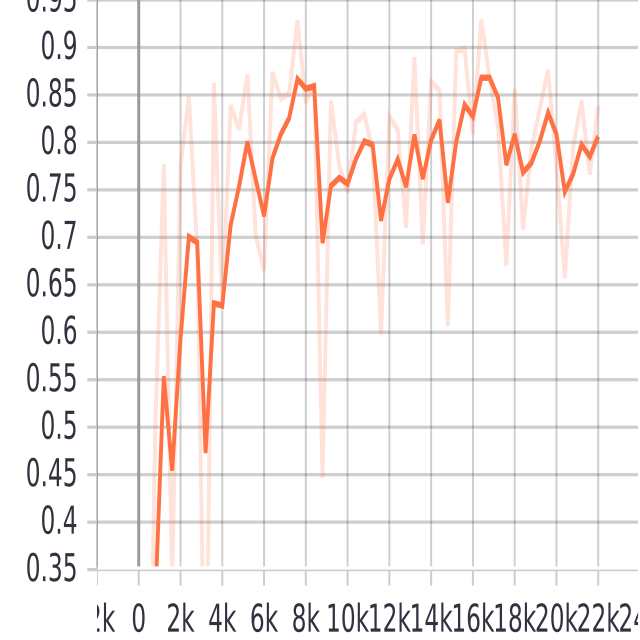

In [89]:
display(Image(filename='figures/normal_run/mean_dice.png', height = 250, width=250))

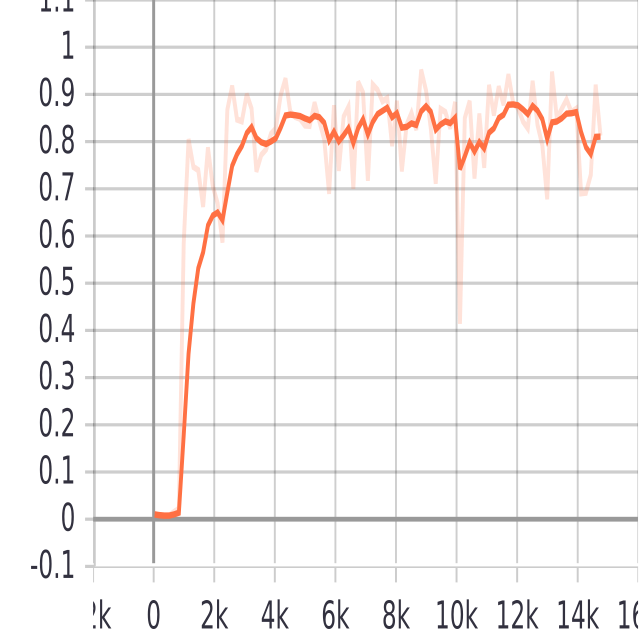

In [90]:
display(Image(filename='figures/client_0_run/mean_dice.png', height = 250, width=250))

In [ ]:
display(Image(filename='figures/client_1_run/mean_dice.png', height = 250, width=250))

# Summary
In this demo, we have configured and trained a federated model.

Two federated clients train the model with their own training data, and share model updates within the FL system;
the server hosts model parameters and synchronise model updates submitted by the two clients.

But this is only a simple demo. There are several features that we haven't investigated in this simple notebook, such as defining your own aggregation method or privacy method. But try it out! You can find all the information that you need in the [Clara documentation] (https://docs.nvidia.com/clara/tlt-mi/clara-train-sdk-v3.0/nvmidl/additional_features/federated_learning.html(. 

In [33]:
%%bash
docker stop server_app
docker stop client_0
docker stop client_1
docker stop client_2
docker stop tensorboard

server_app
client_0
client_1
client_2
tensorboard


In [90]:
!docker ps 

CONTAINER ID        IMAGE               COMMAND             CREATED             STATUS              PORTS               NAMES
